### Initialize

In [29]:
!pip install SALib

In [30]:
import itertools
import csv
from scipy.integrate import solve_ivp
from scipy.integrate import OdeSolver
import multiprocessing
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import csv
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
from tqdm import tqdm
!pip -q install tqdm_joblib        # one-time install (tiny)
from joblib import Parallel, delayed, parallel_config
from tqdm_joblib import tqdm_joblib


### Site Calculation

In [31]:
#Quantify sites using the function below, and pass it on to the rate function
def calculate_sites(cat_wt, m_load, rm, ssa, rsm, Zsm, Zms):
  #Ni metal site quantification
  #metal [=] Ni (used interchangeably in the code)
  mass_ni = m_load * cat_wt  # total mass of Ni, m_Ni
  moles_ni = mass_ni / 58.693  # Total moles of Ni, n_Ni
  na = 6.022e23
  m = moles_ni * na  # Total Ni sites, N_Ni
  vol_ni = (2 / 3) * np.pi * (rm ** 3)  # Volume occupied by 1 Ni particle, V_p
  r_fcc = 0.3506 / (2 * (2 ** 0.5))  # Radius occupied by 1 Ni atom in the fcc bulk structure, r_fcc
  vol_1ni_fcc = (4 / 3) * np.pi * (r_fcc ** 3)  # Volume occupied by 1 fcc Ni atom, V_a
  n_ni = vol_ni / vol_1ni_fcc  # Total Ni atoms in 1 Ni particle, N_Ni,p
  CSA = 2 * np.pi * (rm ** 2)  # Curved Surface Area of 1 Ni particle, CAS_Ni,p
  vol_shell = CSA * (2 * r_fcc)  # Volume of the outermost shells of the hemispherical Ni particle, V_shell
  Nem = vol_shell / vol_1ni_fcc  # Total surface Ni atoms in 1 Ni particle, NS_Ni,p
  NBm = n_ni - Nem  # Total bulk Ni sites in 1 Ni particle
  D = Nem / n_ni  # Dispersion of Ni
  NIm = (np.pi * 2 * rm) / (2 * r_fcc)  # Total Ni interfacial NI sites in 1 Ni particle, NI_Ni,p
  Zmm = ((NIm * 4) + (Nem - NIm) * 6) / Nem  # Number of nearest Ni sites to a Ni site (coordination number)
  n_particles_Ni = m / n_ni  # Total Ni particles, N_p
  Nem_net = Nem * n_particles_Ni  # Total surface metal sites, NS_Ni,tot
  NBm_net = NBm * n_particles_Ni  # Total bulk metal sites
  NIm_net = NIm * n_particles_Ni  # Total interfacial metal sites, NI_Ni,tot
  TSA_Ni_projected = n_particles_Ni * np.pi * ((rm * 1e-9) ** 2)  # Total projected surface area occupied by Ni, A_m

  #CeO2(111) support site quantification
  # support [=] CeO2(111)
  TSA_ceo2 = ssa - TSA_Ni_projected  # Total projected surface area occupied by CeO2(111), A_s
  Zss = 3  # Number of nearest support Ov sites to an Ov site (coordination number)
  areal_density_o_sites = 15.45  # Areal density of lattice Ov on CeO2 (111)
  s = (areal_density_o_sites / 1e-18) * ssa  # Total Ov sites available in A_s, NS_s
  rs = rsm + rm  # Radius of the support, used to calculate interfacial sites
  NIs = np.pi * ((rs ** 2) - (rm ** 2)) * areal_density_o_sites  # Number of interfacial support sites around a single Ni nanoparticle, NI_s,p
  NIs_net = NIs * n_particles_Ni  # Total number of interfacial sites, NI_s
  NNIs_net = s - NIs_net  # Total number of non-interfacial sites, NNI_s
  s2m = s / Nem_net  # Ratio of total expose support to metal sites
  s2mi = NIs_net / NIm_net  # Ratio of total expose support to metal sites
  Zms = 2
  Zsm = 3
  return Zmm, Zss, Nem_net, s, NIm_net, NIs_net

### **Upload data (kinetic params)**

In [32]:
"""
Arrhenius Parameter Retrieval Module
------------------------------------
Retrieves kinetic parameters (k, Keq, Ea, k0) from an Excel file
containing thermodynamic and kinetic data for surface reactions.

The function extracts forward and reverse activation enthalpies,
entropies, and calculates rate constants and equilibrium constants
at a specified temperature.
"""
# -------------------------------------------------------------------
# Retrieve kinetic parameters from the Excel file containing all data
# -------------------------------------------------------------------
def arrhenius_from_excel(
    excel_path: str = "parameters_MKM.xlsx", #Enter excel file name to read the data
    sheet: str = "Refined params", #Which sheet to read?
    T: float = 973.15, #Operating temperature?
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Return rate constants (k), equilibrium constants (Keq),
    activation energies (Ea), and pre-exponential factors (k0)
    from the Excel parameter workbook.

    Parameters
    ----------
    excel_path : str
        Path to the Excel file containing kinetic data.
    sheet : str
        Sheet name where refined parameters are stored.
    T : float
        Temperature in Kelvin for Arrhenius calculations.

    Returns
    -------
    k : np.ndarray
        Combined forward and reverse rate constants.
    K : np.ndarray
        Reaction equilibrium constants (kf/kr).
    Ea : np.ndarray
        Combined forward and reverse activation enthalpies.
    k0 : np.ndarray
        Combined pre-exponential factors.
    """

    # used for calculating rate constants
    R_eV = 8.314 / (1000 * 96.49)

    # Load sheet and detect header row dynamically
    raw = pd.read_excel(excel_path, sheet_name=sheet, header=None)
    header_row = raw[
        raw.apply(lambda r: r.astype(str).str.contains("rate index", case=False).any(), axis=1)
    ].index[0]
    df = pd.read_excel(excel_path, sheet_name=sheet, header=header_row)
    df = df[df["rate index"].notna()].reset_index(drop=True)

    # ------ source columns ------
    Ea_f = pd.to_numeric(df["∆Hf,Ri (eV)"], errors="coerce").astype(float).to_numpy()  # Read the forward Activation enthalpy column, Ea,f [=] ∆Hf,Ri
    Ea_r = pd.to_numeric(df["∆Hr,Ri (eV)"], errors="coerce").astype(float).to_numpy()  # Read the reverse Activation enthalpy column, Ea,r [=] ∆Hr,Ri
    k0_f = pd.to_numeric(df["Af,Ri (s-1)"], errors="coerce").astype(float).to_numpy()  # Read the forward Activation entropy column, k0,f [=] Af,Ri
    k0_r = pd.to_numeric(df["Ar,Ri (s-1)"], errors="coerce").astype(float).to_numpy()  # Read the reverse Activation entropy column, k0,r [=] Ar,Ri

    # Store Activation enthalpy data
    Ea = np.empty(2 * Ea_f.size)
    Ea[0::2], Ea[1::2] = Ea_f, Ea_r

    # Store Activation entropic data
    k0 = np.empty(2 * k0_f.size)
    k0[0::2], k0[1::2] = k0_f, k0_r

    # Calculate kf and kr using numpy's element-wise operations
    kf = k0_f * np.exp(-Ea_f / (R_eV * T))
    kr = k0_r * np.exp(-Ea_r / (R_eV * T))

    # Combine forward/reverse data arrays
    k = np.empty(2 * kf.size)
    k[0::2], k[1::2] = kf, kr

    # Calculate reaction equilibrium constant
    K = kf / kr

    return k, K, Ea, k0


# -------------------------------------------------------------------
# Execute the code
# -------------------------------------------------------------------
if __name__ == "__main__":
    T = 973.15  # Operating temperature?
    k, K, Ea, k0 = arrhenius_from_excel()

    # Save outputs for later use in DRC calculations
    np.save("k.npy", k)
    np.save("Keq.npy", K)
    np.save("Ea.npy", Ea)
    np.save("k0.npy", k0)

    print("k=", k)
    print("Keq=", K)
    print("Ea=", Ea)
    print("k0=", k0)

k= [1.27947322e+09 4.39874966e+13 6.83998061e+06 8.64917784e+08
 8.49850925e+09 5.21881402e+10 8.88858517e+10 1.34198547e+09
 2.21174250e+10 9.65772684e+07 3.22199818e+10 1.49650366e+08
 2.89451884e+05 1.05068617e+07 3.77384543e+12 2.16063813e+05
 2.82287888e+07 1.24183277e+05 7.15044832e+16 6.34460419e+11
 2.56989094e+07 8.44202789e+09 1.20997853e+11 5.89717285e+11
 1.08731189e+04 5.26067093e+09 3.42003997e+10 2.92343813e+10
 2.59708386e+03 1.52537242e+07 3.73375546e+07 1.64012118e+00
 1.61433453e+03 1.13373567e+02]
Keq= [2.90872024e-05 7.90824369e-03 1.62843689e-01 6.62345857e+01
 2.29012741e+02 2.15301724e+02 2.75488431e-02 1.74663465e+07
 2.27315541e+02 1.12701251e+05 3.04416305e-03 2.05179424e-01
 2.06686923e-06 1.16986911e+00 1.70259002e-04 2.27651194e+07
 1.42390733e+01]
Ea= [0.00953467 0.03036377 0.9761085  0.9238915  0.73108534 0.35891466
 0.48108534 0.69891466 0.65687064 0.88312936 0.51090579 0.
 1.5721408  1.0378592  0.2421408  1.4378592  1.10568747 1.35431253
 0.63217053 0.

### **Initialize MKM**

In [33]:
"""
Kinetic Rate and ODE Module
---------------------------
Contains rate expressions for elementary surface reactions and
the system of differential equations (ODEs) describing the time
evolution of surface coverages of intermediates.

Notations and Symbols:
θ  : Surface coverage
k  : Rate constant
p  : Partial pressure
Z  : Coordination number
r  : Reaction rate
"""
# -------------------------------------------------------------------------
# Rate equations for elementary reactions
# -------------------------------------------------------------------------
def rates(theta, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms):
    """
    Compute the rates for all elementary reactions on metal and support sites.

    Parameters
    ----------
    theta : array_like
        Surface coverages of intermediates.
    k : array_like
        Forward and reverse rate constants.
    p : array_like
        Partial pressures of gas-phase species.
    cat_wt : float
        Catalyst weight (g).
    m_load : float
        Metal loading (g).
    rm : float
        Metal particle radius (nm).
    ssa : float
        Specific surface area (m²/g).
    rsm : float
        Interfacial radius (nm).
    Zsm, Zms : float
        Coordination factors between metal and support.

    Returns
    -------
    list of float
        Rates of 34 elementary reactions (r₀ → r₃₃).
    """

    # Retrieve site-related quantities
    Zmm, Zss, NSm, NSs, NIm, NIs = calculate_sites(cat_wt, m_load, rm, ssa, rsm, Zsm, Zms)
    # Zmm, Zms, Zsm, Zss, Nem_net, s, NIm_net, NIs_net are the equivalent parameters defined in calculate_sites()

    r = [0.0] * 34  # Initialize array for 34 elementary reactions
    na = 6.022e23   # Avogadro’s number [mol⁻¹]

    # ---- Metal site reactions ----
    r[0] = k[0]*p[0]*theta[0]*NSm/na                  # r1f
    r[1] = k[1]*theta[1]*NSm/na                       # r1r
    r[2] = k[2]*theta[1]*theta[0]*Zmm*NSm/na          # r2f
    r[3] = k[3]*theta[2]*theta[6]*Zmm*NSm/na          # r2r
    r[4] = k[4]*theta[2]*theta[0]*Zmm*NSm/na          # r3f
    r[5] = k[5]*theta[3]*theta[6]*Zmm*NSm/na          # r3r
    r[6] = k[6]*theta[3]*theta[0]*Zmm*NSm/na          # r4f
    r[7] = k[7]*theta[4]*theta[6]*Zmm*NSm/na          # r4r
    r[8] = k[8]*theta[4]*theta[0]*Zmm*NSm/na          # r5f
    r[9] = k[9]*theta[5]*theta[6]*Zmm*NSm/na          # r5r
    r[10] = k[10]*(theta[6]**2)*Zmm*NSm/na            # r6f
    r[11] = k[11]*p[2]*(theta[0]**2)*Zmm*NSm/na       # r6r
    r[12] = k[12]*theta[4]*theta[7]*Zmm*NSm/na        # r7f
    r[13] = k[13]*theta[9]*theta[0]*Zmm*NSm/na        # r7r
    r[14] = k[14]*theta[9]*theta[0]*Zmm*NSm/na        # r8f
    r[15] = k[15]*theta[8]*theta[6]*Zmm*NSm/na        # r8r
    r[16] = k[16]*theta[5]*theta[7]*Zmm*NSm/na        # r9f
    r[17] = k[17]*theta[8]*theta[0]*Zmm*NSm/na        # r9r
    r[18] = k[18]*theta[8]*NSm/na                     # r10f CO desorption
    r[19] = k[19]*p[3]*theta[0]*NSm/na                # r10r

    # ---- Interfacial O-transport reaction ----
    r[20] = k[20]*theta[0]*theta[13]*Zms*NIs/na       # r11f
    r[21] = k[21]*theta[14]*theta[7]*Zms*NIs/na       # r11r

    # ---- Support (CeO₂) site reactions ----
    r[22] = k[22]*p[1]*theta[14]*NSs/na               # r12f
    r[23] = k[23]*theta[10]*NSs/na                    # r12r
    r[24] = k[24]*theta[10]*NSs/na                    # r13f
    r[25] = k[25]*p[3]*theta[13]*NSs/na               # r13r
    r[26] = k[26]*p[1]*theta[13]*NSs/na               # r14f
    r[27] = k[27]*theta[11]*NSs/na                    # r14r

    # ---- Interfacial O-transport reaction ----
    r[28] = k[28]*theta[0]*theta[11]*Zms*NIs/na       # r15f
    r[29] = k[29]*theta[10]*theta[7]*Zms*NIs/na       # r15r

    # ---- Interfacial H-spillover reactions ----
    r[30] = k[30]*theta[13]*theta[6]*Zsm*NIm/na       # r16f
    r[31] = k[31]*theta[0]*theta[12]*Zsm*NIm/na       # r16r
    r[32] = k[32]*theta[12]*theta[6]*Zsm*NIm/na       # r17f
    r[33] = k[33]*p[4]*theta[0]*theta[14]*Zsm*NIm/na  # r17r

    return r


# -------------------------------------------------------------------------
# Differential equations (ODEs) for surface species coverages
# -------------------------------------------------------------------------
def dt_ode(t, theta, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms):
    """
    Compute time derivatives of surface species coverages (θ̇).

    Parameters
    ----------
    t : float
        Time (s).
    theta : array_like
        Surface coverages of intermediates.
    k : array_like
        Rate constants for all reactions.
    p : array_like
        Partial pressures of gaseous species.
    cat_wt, m_load, rm, ssa, rsm, Zsm, Zms : float
        Catalyst and geometric parameters.

    Returns
    -------
    list of float
        dθ/dt for 15 equations (13 intermediates + 2 site balances).
    """

    # Retrieve reaction rates
    r = rates(theta, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms)

    dt = [0.0] * 15  # Initialize derivatives (15 total ODEs)

    # ODEs: rate of change of surface coverages
    dt[0]  = -(r[0]-r[1])-(r[2]-r[3])-(r[4]-r[5])-(r[6]-r[7])-(r[8]-r[9]) \
             + 2*(r[10]-r[11])+(r[12]-r[13])-(r[14]-r[15])+(r[16]-r[17]) \
             + (r[18]-r[19])-(r[20]-r[21])-(r[28]-r[29])+(r[30]-r[31])+(r[32]-r[33]) #Empty metal sites, *
    dt[1]  = (r[0]-r[1])-(r[2]-r[3])                # CH₄*
    dt[2]  = (r[2]-r[3])-(r[4]-r[5])                # CH₃*
    dt[3]  = (r[4]-r[5])-(r[6]-r[7])                # CH₂*
    dt[4]  = (r[6]-r[7])-(r[8]-r[9])-(r[12]-r[13])  # CH*
    dt[5]  = (r[8]-r[9])-(r[16]-r[17])              # C*
    dt[6]  = (r[2]-r[3])+(r[4]-r[5])+(r[6]-r[7])+(r[8]-r[9]) \
             -2*(r[10]-r[11])+(r[14]-r[15])-(r[30]-r[31])-(r[32]-r[33])  # H*
    dt[7]  = -(r[12]-r[13])-(r[16]-r[17])+(r[20]-r[21])+(r[28]-r[29])     # O*
    dt[8]  = (r[14]-r[15])+(r[16]-r[17])-(r[18]-r[19])                    # CO*
    dt[9]  = (r[12]-r[13])-(r[14]-r[15])                                  # CHO*
    dt[10] = (r[22]-r[23])-(r[24]-r[25])+(r[28]-r[29])                    # CO₂v
    dt[11] = (r[26]-r[27])-(r[28]-r[29])                                  # CO₃v
    dt[12] = (r[30]-r[31])-(r[32]-r[33])                                  # OHv
    dt[13] = -(r[20]-r[21])+(r[24]-r[25])-(r[26]-r[27])-(r[30]-r[31])     # Ov
    dt[14] = (r[20]-r[21])-(r[22]-r[23])+(r[32]-r[33])                    # v

    return dt


Sum of coverages = 1.9999999887981648

Steady-state coverages:
θ[ 0] = 9.1132e-01
θ[ 1] = 1.3254e-05
θ[ 2] = 1.0668e-08
θ[ 3] = 1.0200e-09
θ[ 4] = 3.4486e-08
θ[ 5] = 8.8560e-02
θ[ 6] = 7.1612e-05
θ[ 7] = 3.3047e-05
θ[ 8] = 6.8574e-15
θ[ 9] = 9.5918e-20
θ[10] = 3.1820e-03
θ[11] = 3.3990e-04
θ[12] = 9.6488e-01
θ[13] = 5.8109e-04
θ[14] = 3.1016e-02

Reaction rates:
r[ 0] = 7.3876e+04
r[ 1] = 7.3876e+04
r[ 2] = 6.2134e-02
r[ 3] = 4.9692e-07
r[ 4] = 6.2136e-02
r[ 5] = 2.8668e-06
r[ 6] = 6.2136e-02
r[ 7] = 2.4925e-06
r[ 8] = 5.2277e-01
r[ 9] = 4.6063e-01
r[10] = 1.2427e-01
r[11] = 0.0000e+00
r[12] = 2.4809e-10
r[13] = 6.9072e-16
r[14] = 2.4809e-10
r[15] = 7.9797e-17
r[16] = 6.2134e-02
r[17] = 5.8365e-13
r[18] = 6.2134e-02
r[19] = 0.0000e+00
r[20] = 1.7065e-01
r[21] = 1.0850e-01
r[22] = 3.3700e+06
r[23] = 3.3700e+06
r[24] = 6.2135e-02
r[25] = 0.0000e+00
r[26] = 1.7846e+04
r[27] = 1.7846e+04
r[28] = 1.0087e-05
r[29] = 2.0113e-05
r[30] = 1.9167e-05
r[31] = 1.7791e-05
r[32] = 1.3761e-06
r[33] = 

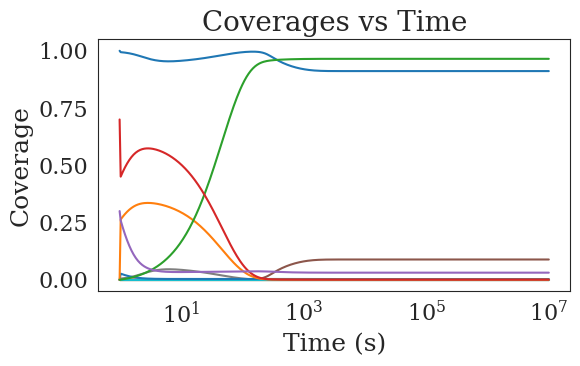

In [34]:
# ---------------------------------------------------------------------
#  ODE SOLVER WRAPPER --------------------------------------------------
# ---------------------------------------------------------------------
def solve_ode(theta0, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms,
              t_final=1e7, n_points=400, tol=1e-7, max_attempts=1000):
    """
    Integrate ODEs until surface coverages converge or maximum attempts reached.

    Parameters
    ----------
    theta0 : ndarray
        Initial surface coverages.
    k : array_like
        Rate constants for all reactions.
    p : array_like
        Partial pressures [pCH4, pCO2, pH2, pCO, pH2O].
    cat_wt, m_load, rm, ssa, rsm, Zsm, Zms : float
        Catalyst and geometric parameters.
    t_final : float, optional
        Initial integration end time (s), default 1e7.
    n_points : int, optional
        Number of points in output trajectory, default 400.
    tol : float, optional
        Convergence tolerance for coverage changes, default 1e-7.
    max_attempts : int, optional
        Maximum retries if solver does not converge, default 1000.

    Returns
    -------
    t : ndarray
        Time points (s).
    theta : ndarray
        Surface coverages over time (shape: n_points x n_species).
    """
    attempt = 0
    t_eval = np.logspace(0, np.log10(t_final), n_points)  # 1 s → t_final
    t_span = (t_eval[0], t_eval[-1])

    while attempt < max_attempts:
        res = solve_ivp(
            fun=lambda t, y: dt_ode(t, y, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms),
            t_span=t_span,
            y0=theta0,
            method='BDF',
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-9
        )

        # Check convergence using last two points
        if res.y.shape[1] >= 2:
            max_diff = np.max(np.abs(res.y[:, -1] - res.y[:, -2]))
        else:  # Solver returned only one point → retry
            max_diff = np.inf

        if max_diff < tol:
            break

        # Not converged → extend time span and retry
        theta0 = np.maximum(res.y[:, -1], 0)
        t_final *= 10
        t_eval = np.logspace(0, np.log10(t_final), n_points)
        t_span = (t_eval[0], t_eval[-1])
        attempt += 1

    if attempt == max_attempts:
        raise RuntimeError(f"Coverage did not converge after {max_attempts} attempts.")

    return res.t, res.y.T  # shape: (n_points,), (n_points, n_species)


# ---------------------------------------------------------------------
#  MAIN EXECUTION -----------------------------------------------------
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # ----- Initial conditions & operating parameters -----------------
    theta0 = np.array([
        1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.7, 0.3
    ])
    p       = [0.5, 0.5, 0.0, 0.0, 0]   # pCH4, pCO2, pH2, pCO, pH2O
    cat_wt  = 1.0                       #Total catalyst weight (in grams)
    m_load  = 0.04                      #Catalyst loading (in grams)
    rm      = 4                         # Radius of Ni nanoparticle (nm)
    ssa     = 70.0                      # Specific surface area of the catalyst (m2/g)
    rsm     = 0.38                      # Interfacial radius, r_int (nm)
    Zsm     = 3.0
    Zms     = 2.0

    # ----- Integrate ODEs --------------------------------------------
    t, theta = solve_ode(theta0, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms)
    steady_state = theta[-1]

    # ----- Print coverage summary ------------------------------------
    print("Sum of coverages =", np.sum(steady_state))
    print("\nSteady-state coverages:")
    for i, cov in enumerate(steady_state):
        print(f"θ[{i:2}] = {cov:9.4e}")

    # ----- Compute reaction rates -------------------------------------
    r = rates(steady_state, k, p, cat_wt, m_load, rm, ssa, rsm, Zsm, Zms)
    print("\nReaction rates:")
    for i, rate in enumerate(r):
        print(f"r[{i:2}] = {rate:9.4e}")

    # ----- Compute net rates -------------------------------------------
    net_rates = [r[i] - r[i + 1] for i in range(0, len(r), 2)]
    reaction_labels = [f"R{i+1}" for i in range(len(net_rates))]

    # ----- Create DataFrame for rates ---------------------------------
    df_rates = pd.DataFrame({
        "Reaction": reaction_labels,
        "Forward rate": r[0::2],
        "Reverse rate": r[1::2],
        "Net rate": net_rates
    })

    # ----- Create DataFrame for final coverages -----------------------
    df_coverages = pd.DataFrame(steady_state.reshape(1, -1), columns=[f"θ_{i}" for i in range(len(steady_state))])
    df_coverages.insert(0, "Time(s)", [t[-1]])  # Add final time as first column

    # ----- Save both rates and final coverages in one Excel file -------
    with pd.ExcelWriter("mkm_results.xlsx", engine='openpyxl') as writer:
        df_rates.to_excel(writer, sheet_name="Rates", index=False)
        df_coverages.to_excel(writer, sheet_name="Final Coverages", index=False)

    # ----- Plot coverages vs time --------------
    plt.figure(figsize=(6, 4))
    for i in range(theta.shape[1]):
        plt.plot(t, theta[:, i], label=f'θ_{i}')
    plt.xscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Coverage')
    plt.title('Coverages vs Time')
    plt.tight_layout()
    plt.show()

    # Optional: save legend as separate figure
    fig_legend = plt.figure(figsize=(2, 4))
    fig_legend.legend([f'θ_{i}' for i in range(theta.shape[1])],
                      loc='center')
    fig_legend.tight_layout()
    fig_legend.savefig("coverage_legend.png", dpi=300)
    plt.close(fig_legend)

### Sobol Analysis setup


In [40]:
# ---------------------------------------------------------------------
#  Sobol Sensitivity Analysis Setup
# ---------------------------------------------------------------------
# Copy the base rate constant array to preserve the original
k1 = k.copy()

# ---------------------------------------------------------------------
#  Define Sobol Problem Specification
# ---------------------------------------------------------------------
# The 'problem' dictionary defines the input parameters for the Sobol analysis.
# It includes:
#   - 'num_vars': total number of uncertain parameters
#   - 'names': human-readable names (with LaTeX formatting for clarity in plots)
#   - 'bounds': lower and upper limits for each parameter

problem = {
    # Total number of parameters
    'num_vars': 16,

    # Parameter names (in LaTeX math formatting for nicer visualization)
    'names': [
        r'$\mathrm{r_{m}}$',       # Metal nanoparticle radius
        r'$\mathrm{r_{int}}$',     # Interfacial radius
        r'$\mathrm{Z^{s,m}}$',     # Coordination number
        r'$\mathrm{Z^{m,s}}$',     # Coordination number
        r'$\mathrm{p_{CH_4}}$',    # Methane partial pressure
        r'$\mathrm{p_{H_2}}$',     # Hydrogen partial pressure
        r'$\mathrm{p_{CO}}$',      # CO partial pressure
        r'$\mathrm{p_{H_2O}}$',    # Water partial pressure
        r'$\mathrm{k_2}$',         # Forward rate constant of R2
        r'$\mathrm{k_6}$',         # Forward rate constant of R6
        r'$\mathrm{k_9}$',         # Forward rate constant of R9
        r'$\mathrm{k_{11}}$',      # Forward rate constant of R11
        r'$\mathrm{k_{13}}$',      # Forward rate constant of R13
        r'$\mathrm{k_{15}}$',      # Forward rate constant of R15
        r'$\mathrm{k_{16}}$',      # Forward rate constant of R16
        r'$\mathrm{k_{17}}$'       # Forward rate constant of R17
    ],

    # Parameter bounds: [lower_bound, upper_bound] for each parameter
    # These reflect physical or empirical uncertainty ranges.
    'bounds': [
        [2, 10],                      # r_m: Metal nanoparticle radius
        [0.25, 1],                    # r_int: Interfacial radius
        [1, 4],                       # Z_sm: Surface-to-metal coordination
        [1, 4],                       # Z_ms: Metal-to-surface coordination
        [0.75 * 0.5, 1.25 * 0.5],     # p_CH4: ±25% variation around 0.5 bar
        [0.75 * 0.04, 1.25 * 0.04],   # p_H2:  ±25% variation around 0.04 bar
        [0.75 * 0.04, 1.25 * 0.04],   # p_CO:  ±25% variation around 0.04 bar
        [0.75 * 0.02, 1.25 * 0.02],   # p_H2O: ±25% variation around 0.02 bar
        [0.75 * k1[2],  1.25 * k1[2]],# k2: forward rate constant (R2)
        [0.75 * k[10],  1.25 * k[10]],# k6: forward rate constant (R6)
        [0.75 * k[16],  1.25 * k[16]],# k9: forward rate constant (R9)
        [0.75 * k[20],  1.25 * k[20]],# k11: forward rate constant (R11)
        [0.75 * k[24],  1.25 * k[24]],# k13: forward rate constant (R13)
        [0.75 * k[28],  1.25 * k[28]],# k15: forward rate constant (R15)
        [0.75 * k[30],  1.25 * k[30]],# k16: forward rate constant (R16)
        [0.75 * k[32],  1.25 * k[32]] # k17: forward rate constant (R17)
    ]
}


# Sobol for a single N size

In [41]:
# ---------------------------------------------------------------------
#  ODE Evaluation Wrapper (Thread-Safe, Timeout-Protected)
# ---------------------------------------------------------------------
#  This module runs a single ODE simulation using provided parameters.
#  It enforces a time limit per solve (no need for extra pip installs).
#  If an ODE run fails or times out, it safely returns np.nan results.
# ---------------------------------------------------------------------

from concurrent.futures import ThreadPoolExecutor, TimeoutError

# Maximum time allowed (in seconds) for one ODE integration
TIME_LIMIT = 25  # Adjust as needed for your solver speed and stability


def run_model_one(params):
    """
    Run a single microkinetic simulation for the given parameter set.

    Parameters
    ----------
    params : list or tuple
        Contains the following 16 input variables:
            rm, rsm, Zsm, Zms, pCH4, pH2, pCO, pH2O,
            k2, k6, k9, k11, k13, k15, k16, k17

    Returns
    -------
    tuple
        (net_H2_rate, H2_selectivity)
        Returns np.nan for both if the ODE fails or exceeds the time limit.
    """

    def _simulate():
        """Inner simulation routine for one parameter set."""

        # --------------------------------------------------------------
        # 1. Unpack parameter vector
        # --------------------------------------------------------------
        (rm, rsm, Zsm, Zms,
         pCH4, pH2, pCO, pH2O,
         k2, k6, k9, k11, k13, k15, k16, k17) = params

        # --------------------------------------------------------------
        # 2. Construct local rate constant array
        # --------------------------------------------------------------
        # Backward rate constants (k[i+1]) are calculated from
        # corresponding forward constants (k[i]) and equilibrium constants (K[i])
        # to maintain the thermodynamic state of the system.
        k_loc = k.copy()
        k_loc[ 2] = k2;  k_loc[ 3] = k2  / K[ 1]
        k_loc[10] = k6;  k_loc[11] = k6  / K[ 5]
        k_loc[16] = k9;  k_loc[17] = k9  / K[ 8]
        k_loc[20] = k11; k_loc[21] = k11 / K[10]
        k_loc[24] = k13; k_loc[25] = k13 / K[12]
        k_loc[28] = k15; k_loc[29] = k15 / K[14]
        k_loc[30] = k16; k_loc[31] = k16 / K[15]
        k_loc[32] = k17; k_loc[33] = k17 / K[16]

        # --------------------------------------------------------------
        # 3. Set initial coverages and gas-phase partial pressures
        # --------------------------------------------------------------
        # Partial pressures are passed as a list in order:
        # [pCH4, pCH4, pH2, pCO, pH2O]
        p  = [pCH4, pCH4, pH2, pCO, pH2O]

        # Initial surface coverages for 16 species
        θ0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0.3])

        # --------------------------------------------------------------
        # 4. Integrate the microkinetic model (ODE system)
        # --------------------------------------------------------------
        _, θ = solve_ode(
            θ0, k_loc, p,
            cat_wt=1, m_load=0.04,
            rm=rm, ssa=70, rsm=rsm,
            Zsm=Zsm, Zms=Zms
        )

        # --------------------------------------------------------------
        # 5. Compute reaction rates at steady-state coverages
        # --------------------------------------------------------------
        r = rates(
            θ[-1], k_loc, p,
            cat_wt=1, m_load=0.04,
            rm=rm, ssa=70, rsm=rsm,
            Zsm=Zsm, Zms=Zms
        )

        # --------------------------------------------------------------
        # 6. Calculate performance metrics
        # --------------------------------------------------------------
        # Net H2 formation rate
        net_H2 = r[10] - r[11]

        # Denominator for selectivity (net CO production)
        denom = (r[18] - r[19]) + (r[24] - r[25])

        # H2 selectivity
        sel_H2 = net_H2 / denom if denom != 0 else np.nan

        return np.float32(net_H2), np.float32(sel_H2)

    # -----------------------------------------------------------------
    # 7. Run the simulation safely with a timeout protection
    # -----------------------------------------------------------------
    try:
        with ThreadPoolExecutor(max_workers=1) as ex:
            future = ex.submit(_simulate)
            return future.result(timeout=TIME_LIMIT)

    except TimeoutError:
        # Timeout occurred → mark run as failed
        return np.nan, np.nan

    except Exception:
        # Any runtime or numerical error → mark run as failed
        return np.nan, np.nan


In [42]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import numpy as np
from SALib.sample import sobol as sobol_sample  # Sobol sampling (new API)

# ───────────────────────────────────────────────────────────────
# 1. Generate Sobol samples
# ───────────────────────────────────────────────────────────────
# 'problem' is the SALib problem dictionary containing 'num_vars',
# 'names', and 'bounds' for your 16 input variables.
# N = 8 → base sample size; calc_second_order=True generates
# second-order interaction samples as well.
param_values = sobol_sample.sample(problem, N=8, calc_second_order=True)

# ───────────────────────────────────────────────────────────────
# 2. Run microkinetic model (MKM) in parallel
# ───────────────────────────────────────────────────────────────
# Each parameter vector `p` is passed to `run_model_one`.
# Output: (net_H2_rate, H2_selectivity)
results = Parallel(
    n_jobs=-1,            # Use all available CPU cores
    backend="loky"        # Process-based parallelism
)(
    delayed(run_model_one)(p) for p in tqdm(param_values)
)

# ───────────────────────────────────────────────────────────────
# 3. Convert results to NumPy array
# ───────────────────────────────────────────────────────────────
# Each element of 'results' is a tuple → shape (n_samples, 2)
results = np.asarray(results, dtype=np.float32)

# ───────────────────────────────────────────────────────────────
# 4. Filter out failed runs
# ───────────────────────────────────────────────────────────────
# Mask keeps only rows where both outputs are valid (not NaN)
mask = ~np.isnan(results).any(axis=1)

# Apply mask to parameter vectors and outputs
params     = param_values[mask]          # Sobol parameter sets for successful runs
rate_out   = results[mask, 0]           # Net H2 production rate
sel_out    = results[mask, 1]           # H2 selectivity

# ───────────────────────────────────────────────────────────────
# 5. Summary
# ───────────────────────────────────────────────────────────────
# After this, 'params', 'rate_out', and 'sel_out' contain only
# valid runs and can be used for further sensitivity analysis
# (e.g., Sobol indices, plotting, etc.).


  0%|          | 0/272 [00:00<?, ?it/s]

In [44]:
from SALib.analyze import sobol
import pandas as pd
import numpy as np

# ───────────────────────────────────────────────────────────────
# 1. Run Sobol sensitivity analysis for both outputs
# ───────────────────────────────────────────────────────────────
# rate_out   : Net H2 production rate
# sel_out    : H2 selectivity
# problem    : SALib problem dictionary (names, bounds, num_vars)
Si_rate = sobol.analyze(problem, rate_out, calc_second_order=True, print_to_console=True)
Si_sel  = sobol.analyze(problem, sel_out,  calc_second_order=True, print_to_console=True)

# ───────────────────────────────────────────────────────────────
# 2. First- and total-order indices → tidy tables
# ───────────────────────────────────────────────────────────────
# Net H2 rate
s1_df_rate = pd.DataFrame({
    "Parameter": problem["names"],
    "S1":        Si_rate["S1"],        # First-order indices
    "ST":        Si_rate["ST"],        # Total-order indices
    "S1_conf":   Si_rate["S1_conf"],   # Confidence intervals
    "ST_conf":   Si_rate["ST_conf"],
})
s1_df_rate["Metric"] = "Net H₂ rate"

# H2 selectivity
s1_df_sel = pd.DataFrame({
    "Parameter": problem["names"],
    "S1":        Si_sel["S1"],
    "ST":        Si_sel["ST"],
    "S1_conf":   Si_sel["S1_conf"],
    "ST_conf":   Si_sel["ST_conf"],
})
s1_df_sel["Metric"] = "H₂ selectivity"

# Combine both metrics into one table
s1_df = pd.concat([s1_df_rate, s1_df_sel], ignore_index=True)

# ───────────────────────────────────────────────────────────────
# 3. Second-order indices (parameter pairs)
# ───────────────────────────────────────────────────────────────
s2_rows = []
num_params = len(problem["names"])
for i in range(num_params):
    for j in range(i + 1, num_params):
        s2_rows.append({
            "Param1":      problem["names"][i],
            "Param2":      problem["names"][j],
            "S2_rate":     Si_rate["S2"][i, j],       # Second-order index for net H2
            "S2_rate_conf":Si_rate["S2_conf"][i, j],  # Confidence interval
            "S2_sel":      Si_sel["S2"][i, j],       # Second-order index for selectivity
            "S2_sel_conf": Si_sel["S2_conf"][i, j],
        })
s2_df = pd.DataFrame(s2_rows)

# ───────────────────────────────────────────────────────────────
# 4. Raw simulation results (input parameters + outputs)
# ───────────────────────────────────────────────────────────────
raw_df = pd.DataFrame(params, columns=problem["names"])
raw_df["r_H2_production"] = rate_out
raw_df["H2_selectivity"]  = sel_out

# ───────────────────────────────────────────────────────────────
# 5a. Save Sobol sensitivity indices to Excel
# ───────────────────────────────────────────────────────────────
outfile_sobol = "sobol_indices.xlsx"
with pd.ExcelWriter(outfile_sobol, engine="openpyxl") as writer:
    s1_df.to_excel(writer, sheet_name="S1_indices", index=False)
    s2_df.to_excel(writer, sheet_name="S2_indices", index=False)

print(f"✔ Sobol indices saved to {outfile_sobol}")

# ───────────────────────────────────────────────────────────────
# 5b. Save raw simulation results to a separate Excel file
# ───────────────────────────────────────────────────────────────
outfile_raw = "sobol_raw_results.xlsx"
with pd.ExcelWriter(outfile_raw, engine="openpyxl") as writer:
    raw_df.to_excel(writer, sheet_name="Raw_results", index=False)

print(f"✔ Raw simulation results saved to {outfile_raw}")


                               ST       ST_conf
$\mathrm{r_{m}}$     6.773292e-01  7.355827e-01
$\mathrm{r_{int}}$   4.802623e-02  5.138244e-02
$\mathrm{Z^{s,m}}$   2.463594e-04  7.406728e-04
$\mathrm{Z^{m,s}}$   4.142733e-02  4.218431e-02
$\mathrm{p_{CH_4}}$  2.618041e-02  2.534415e-02
$\mathrm{p_{H_2}}$   9.356158e-05  1.231554e-04
$\mathrm{p_{CO}}$    1.958725e-02  2.178005e-02
$\mathrm{p_{H_2O}}$  1.898183e-05  2.712543e-05
$\mathrm{k_2}$       7.746157e-02  1.348702e-01
$\mathrm{k_6}$       7.740591e-14  1.355022e-13
$\mathrm{k_9}$       1.749244e-01  1.974694e-01
$\mathrm{k_{11}}$    3.944044e-03  4.173931e-03
$\mathrm{k_{13}}$    1.219956e-14  1.986941e-14
$\mathrm{k_{15}}$    2.342796e-09  3.134347e-09
$\mathrm{k_{16}}$    8.477650e-05  1.272274e-04
$\mathrm{k_{17}}$    1.372357e-05  1.643592e-05
                               S1       S1_conf
$\mathrm{r_{m}}$     9.155990e-01  6.427579e-01
$\mathrm{r_{int}}$   4.302283e-02  2.106321e-01
$\mathrm{Z^{s,m}}$  -7.043423e-05  1.379

▶ Plotting Sobol results for: Net H₂ rate


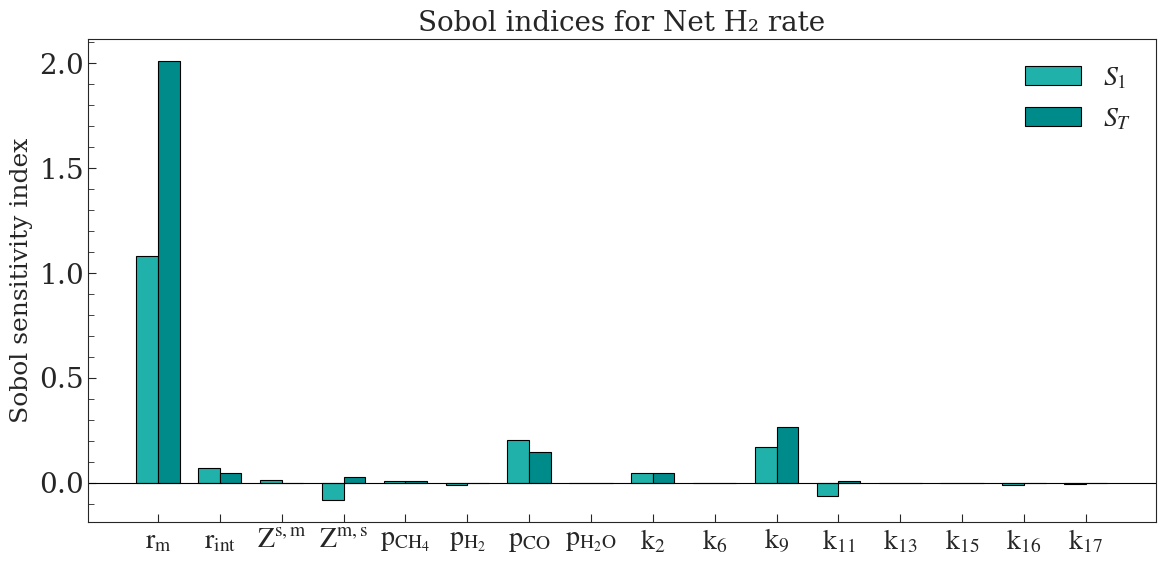

▶ Plotting Sobol results for: H₂ selectivity


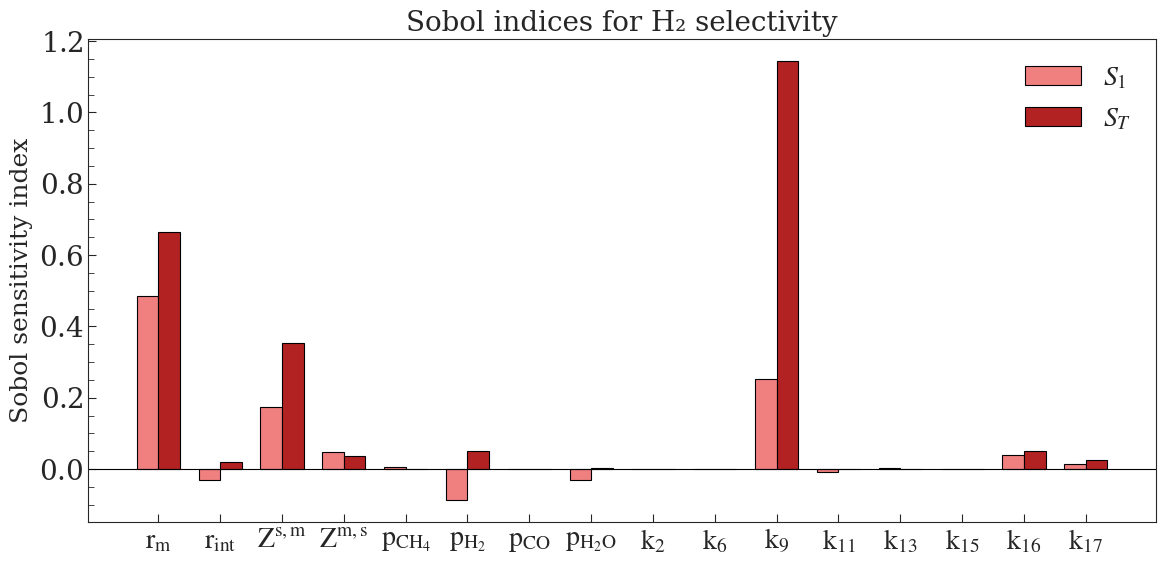

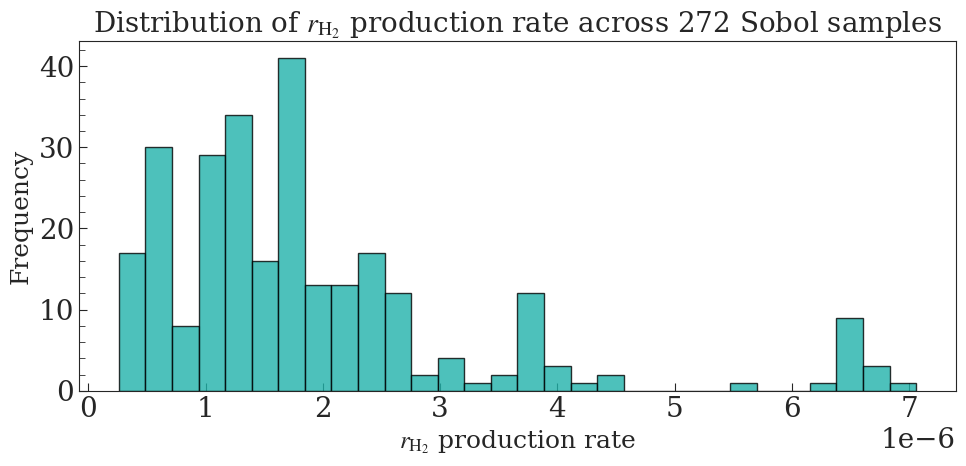

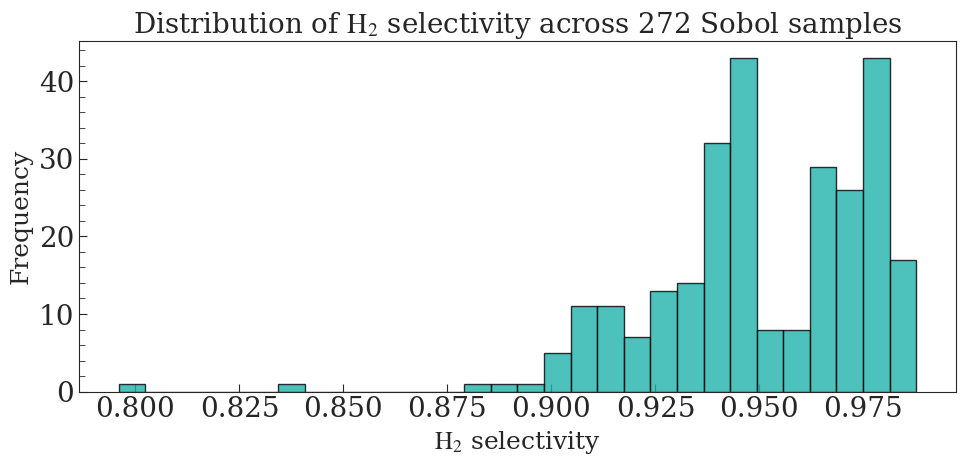

In [39]:
# ───────────────────────────────────────────────────────────────
# 0.  Imports & global style
# ───────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, NullLocator

use_latex = False
plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "text.usetex": use_latex,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
})

# Helper: inward tick styling
def _ticks_in_custom(ax):
    ax.tick_params(axis='both', which='major', direction='in', length=6,
                   bottom=True, left=True, top=False, right=False)
    ax.tick_params(axis='y', which='minor', direction='in', length=4,
                   left=True, right=False, top=False, bottom=False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(NullLocator())

# Helper: scientific formatter like ×10⁻ʸ
def _format_sci_notation(ax, axis='y'):
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    if axis == 'y':
        ax.yaxis.set_major_formatter(formatter)
        plt.draw()
        offset_text = ax.yaxis.get_offset_text().get_text()
        ax.yaxis.get_offset_text().set_visible(False)
        return offset_text
    else:
        ax.xaxis.set_major_formatter(formatter)
        plt.draw()
        offset_text = ax.xaxis.get_offset_text().get_text()
        ax.xaxis.get_offset_text().set_visible(False)
        return offset_text


# ───────────────────────────────────────────────────────────────
# 1.  Load separate Excel files
# ───────────────────────────────────────────────────────────────
s1_df   = pd.read_excel("sobol_indices.xlsx", sheet_name="S1_indices")
s2_df   = pd.read_excel("sobol_indices.xlsx", sheet_name="S2_indices")
raw_df  = pd.read_excel("sobol_raw_results.xlsx", sheet_name="Raw_results")

param_col_s1 = "Parameter" if "Parameter" in s1_df.columns else "names"
param_col_s2_1 = "Param1" if "Param1" in s2_df.columns else "Parameter 1"
param_col_s2_2 = "Param2" if "Param2" in s2_df.columns else "Parameter 2"


# ───────────────────────────────────────────────────────────────
# 2.  Order parameters
# ───────────────────────────────────────────────────────────────
all_params = s1_df[param_col_s1].unique()
k_params = sorted([p for p in all_params if p.startswith('k')],
                  key=lambda p: int(p[1:].replace('_','')))
non_k_params = [p for p in all_params if not p.startswith('k')]
preferred_non_k_order = [
    r'$\text{r}_{\text{m}}$',
    r'$\text{r}_{\text{int}}$',
    r'$\text{Z}^{\text{s,,m}}$',
    r'$\text{Z}^{\text{m,,s}}$',
    r'$\text{p}_{\text{CH}_4}$',
    r'$\text{p}_{\text{H}_2}$',
    r'$\text{p}_{\text{CO}}$',
    r'$\text{p}_{\text{H}_2\text{O}}$'
]

ordered_non_k_params = [p for p in preferred_non_k_order if p in non_k_params] \
                        + [p for p in non_k_params if p not in preferred_non_k_order]
ordered_params = ordered_non_k_params + k_params
ordered_params = [p for p in ordered_params if p in all_params]


# ───────────────────────────────────────────────────────────────
# 3.  Plot Sobol S1/ST per metric
# ───────────────────────────────────────────────────────────────
metrics = s1_df["Metric"].unique()

for metric in metrics:
    print(f"▶ Plotting Sobol results for: {metric}")
    s1_sub = s1_df[s1_df["Metric"] == metric].set_index(param_col_s1).loc[ordered_params].reset_index()

    x, w = np.arange(len(ordered_params)), 0.35

    # Choose color palette based on metric type
    if "selectivity" in metric.lower():
        c_s1, c_st = "lightcoral", "firebrick"
    else:
        c_s1, c_st = "lightseagreen", "darkcyan"

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - w/2, s1_sub["S1"], w, color=c_s1, label=r"$S_1$", edgecolor="black", linewidth=0.8)
    ax.bar(x + w/2, s1_sub["ST"], w, color=c_st, label=r"$S_T$", edgecolor="black", linewidth=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(ordered_params, rotation=0, ha="center")
    ax.set_ylabel("Sobol sensitivity index")
    ax.set_title(f"Sobol indices for {metric}")
    ax.axhline(0, color="black", lw=0.8)

    _ticks_in_custom(ax)

    # Apply nice scientific notation (on y-axis)
    offset_text = _format_sci_notation(ax, axis='y')
    if offset_text:
        ax.set_ylabel(f"Sobol sensitivity index {offset_text}")

    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(f"Sobol_{metric.replace(' ', '_')}.png", dpi=300)
    plt.show()


# ───────────────────────────────────────────────────────────────
# 4.  Histogram plots
# ───────────────────────────────────────────────────────────────
hist_targets = [
    ("r_H2_production", r"$r_{\mathrm{H_2}}$ production rate"),
    ("H2_selectivity",  r"$\mathrm{H_2}$ selectivity"),
]

for colname, label in hist_targets:
    if colname not in raw_df.columns:
        continue

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(raw_df[colname].dropna(), bins=30, color="lightseagreen", edgecolor="black", alpha=0.8)

    ax.set_xlabel(label)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {label} across {len(raw_df)} Sobol samples")
    _ticks_in_custom(ax)
    fig.tight_layout()
    fig.savefig(f"Hist_{colname}.png", dpi=300)
    plt.show()
